In [1]:
from datasets.nuscenes_dataset import NuScenesDataset

In [2]:
import os 
nuscenes_dataset_path = '/home/cedric/Downloads/nuScenes/' 
sam_labels_path = None
sequence = 1

dataset = NuScenesDataset(nuscenes_dataset_path,sequence, 
                       sam_labels_path)


Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.331 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
from segmentation.aggregated_segmentation import AggregatedSegmentation

aggregated_segmentation = AggregatedSegmentation(dataset,dataset_name='nuScenes',sequence=sequence,window=5)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
PatchWorkpp::PatchWorkpp() - INITIALIZATION COMPLETE


### Run baselines

In [4]:
import os
import numpy as np

from tqdm import tqdm

visual_labels = []
geometrical_labels = []
gt_labels = []

cnt = 0 
for i in tqdm(range(0, len(dataset))):
    geometrical_labels.append(aggregated_segmentation.segment_instances(i))
    gt_labels.append(dataset.get_panoptic_labels(i))

    cnt += 1


100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


### Visualize baselines

In [5]:
import random

def generate_random_colors(N):
    colors = []
    for _ in range(N):
        colors.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

    return colors

random_colors = generate_random_colors(100)

In [6]:
import numpy as np
import open3d as o3d

def color_points_by_labels(points, labels):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    colors = []
    unique_clusters = list(np.unique(labels))
    for i in range(labels.shape[0]):
        colors.append(random_colors[unique_clusters.index(labels[i]) + 1])

    pcd.colors = o3d.utility.Vector3dVector(np.vstack(colors) / 255)

    return pcd

In [7]:
index = 0
points = dataset.get_point_cloud(index)
#o3d.visualization.draw_geometries([color_points_by_labels(points, gt_labels[index])])
o3d.visualization.draw_geometries([color_points_by_labels(points[:,:3], geometrical_labels[index])])

### Evaluation

In [8]:
import instanseg
from instanseg.metrics import precision, recall, fScore

instanseg.metrics.constants.IOU_THRESHOLD_FULL = 0.5
tp_condition = 'iou'

In [9]:
import pandas as pd

results_dict = []

for i in tqdm(range(len(geometrical_labels))):

        res = {
            'index': i,
            'method': 'dbscan clustering aggregated' + str(aggregated_segmentation.window),
            'precision': precision(geometrical_labels[i].reshape(-1,), gt_labels[i], tp_condition),
            'recall': recall(geometrical_labels[i].reshape(-1,), gt_labels[i], tp_condition),
            'fscore': fScore(geometrical_labels[i].reshape(-1,), gt_labels[i], tp_condition)
        }
        
        results_dict.append(res)
    


 50%|█████     | 20/40 [00:08<00:09,  2.18it/s]

In [ ]:
df = pd.DataFrame.from_records(results_dict, index=np.arange(len(results_dict)))

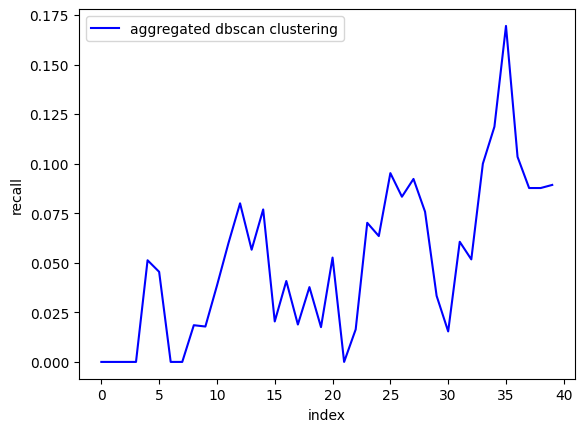

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'recall'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
plt.plot(df['index'].values, df[metric].values,color='blue',label='aggregated dbscan clustering')

plt.legend()

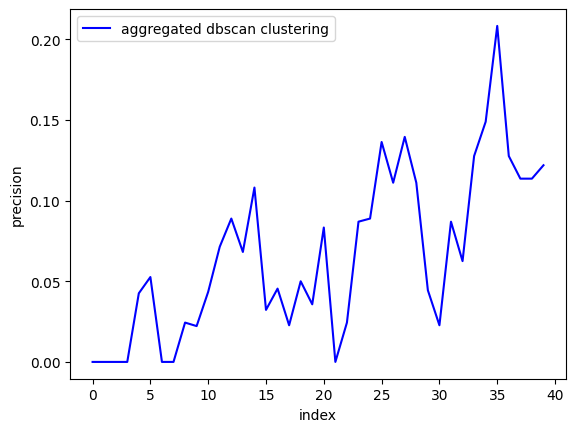

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'precision'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
plt.plot(df['index'].values, df[metric].values,color='blue',label='aggregated dbscan clustering')

plt.legend()

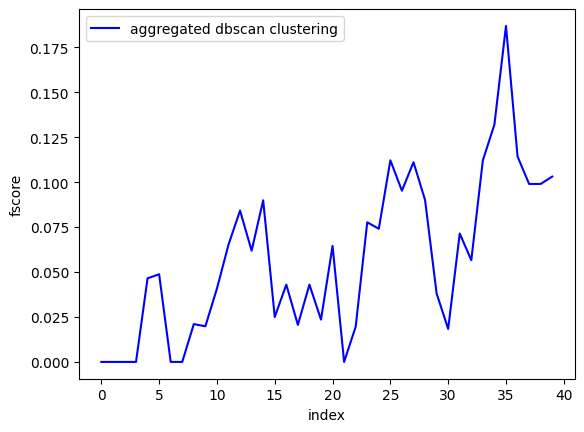

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('index')  # Optional: Add X-axis label
metric = 'fscore'
plt.ylabel(metric)  # Optional: Add Y-axis label
colors = ['blue','orange','red']
plt.plot(df['index'].values, df[metric].values,color='blue',label='aggregated dbscan clustering')

plt.legend()

### Table for comparing averaged metrics over the dataset

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names =  ['Metric'] +  ['DBScan Aggregated Method 3']

metrics = ['recall','precision','fscore']
for i in range(3): 
        row = [metrics[i]]
        row.append(round(df[metrics[i]].mean(),3))
        table.add_row(row)

print(table)

+-----------+----------------------------+
|   Metric  | DBScan Aggregated Method 3 |
+-----------+----------------------------+
|   recall  |           0.051            |
| precision |           0.067            |
|   fscore  |           0.058            |
+-----------+----------------------------+
